In [ ]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('banana_quality.csv')

In [3]:
df.head()

,Size,Weight,Sweetness,Softness,HarvestTime,Ripeness,Acidity,Quality
0,-1.924968,0.468078,3.077832,-1.472177,0.294799,2.435570,0.271290,Good
1,-2.409751,0.486870,0.346921,-2.495099,-0.892213,2.067549,0.307325,Good
2,-0.357607,1.483176,1.568452,-2.645145,-0.647267,3.090643,1.427322,Good
3,-0.868524,1.566201,1.889605,-1.273761,-1.006278,1.873001,0.477862,Good
4,0.651825,1.319199,-0.022459,-1.209709,-1.430692,1.078345,2.812442,Good


In [4]:
X = df.drop(columns=['Quality']).values
y = df['Quality'].apply(lambda x: 1 if x == "Good" else -1).values

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
from ridge import LinearRegressionRidge

clf = LinearRegressionRidge(lam=2)

clf.fit(X_train, y_train)

accuracy_score(y_test, clf.predict(X_test))

0.88875

In [8]:
from linear import LinearClassificationGD

clf = LinearClassificationGD(alpha=0.1, risk="log")

clf.fit(X_train, y_train)

accuracy_score(y_test, clf.predict(X_test))

0.886875

### 1. Ядра
- **Линейное**:
  $$K(x_1, x_2) = x_1 \cdot x_2$$

- **RBF**:
  $$K(x_1, x_2) = \exp(-\gamma \|x_1 - x_2\|^2)$$

- **Полиномиальное**:
  $$K(x_1, x_2) = (\gamma x_1 \cdot x_2 + r)^d$$

### 3. Оптимизация
- **Предсказание**:
  $$f(x) = \sum_{i=1}^{N} \alpha_i y_i K(x_i, x) + b$$

- **Ошибка**:
  $$E_i = f(x_i) - y_i$$

- **Обрезка $alpha$**:
  $$\alpha_{new} = \min(\max(\alpha_{old}, L), H)$$

- **Обновление $b$**

### 4. Алгоритм
- SMO выбирает пары $\alpha$, которые оптимизирует
- Для каждой пары считает границы $L$ и $H$, ошибку, и лучший $\alpha$ в границах
- $b$ обновляется на основе $\alpha$
- Повтор

### 5. Гиперпараметры
- **C**: баланс ширины окна и минимизации функции ошибки
- **tol**: граница при которой определяется, нарушается для условие KKT
- $\gamma$, $r$, $d$: всякие параметры

In [9]:
from svm import SVM

clf = SVM(kernel="linear", epochs=10)

clf.fit(X_train, y_train)

accuracy_score(y_test, clf.predict(X_test))

0.76

### Гиперпараметры

In [10]:
import optuna

optuna.logging.set_verbosity(optuna.logging.WARNING)


def objective_for_linear(trial):
    model = LinearClassificationGD(
        learning_rate=trial.suggest_float("learning_rate", 1e-5, 1e-4),
        regularization=trial.suggest_categorical(name="regularization", choices=["", "elastic_net"]),
        lam=trial.suggest_float("lam", 0, 1),
        alpha=trial.suggest_float("alpha", 0, 1),
        epochs=trial.suggest_int("epochs", 100, 1000),
        risk=trial.suggest_categorical(name="risk", choices=["log", "squared", "hinge"]),
    )

    model.fit(X_train, y_train)

    preds = model.predict(X_test)

    return accuracy_score(y_test, preds)


study_linear = optuna.create_study(direction="maximize")
study_linear.optimize(objective_for_linear, n_trials=1_000, show_progress_bar=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [11]:
study_linear.best_trial.params

{'learning_rate': 4.250045426352303e-05,
 'regularization': '',
 'lam': 0.0030549589025969867,
 'alpha': 0.8623829423031583,
 'epochs': 325,
 'risk': 'log'}

In [12]:
from svm import SVM

def objective_for_svm(trial):
    model = SVM(
        kernel=trial.suggest_categorical(name="kernel", choices=["poly", "rbf", "linear"]),
        C=trial.suggest_float("C", 0.01, 10, log=True),
        tol=trial.suggest_float("tol", 1e-5, 1, log=True),
        gamma=trial.suggest_float("gamma", 0, 1),
        r=trial.suggest_float("r", -2, 2),
        d=trial.suggest_int("d", 1, 5),
        epochs=trial.suggest_int("epochs", 2, 10),
    )

    model.fit(X_train, y_train)

    preds = model.predict(X_test)

    return accuracy_score(y_test, preds)

study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(objective_for_svm, n_trials=100, show_progress_bar=True, n_jobs=12)

  0%|          | 0/100 [00:00<?, ?it/s]

In [13]:
study_svm.best_trial.params

{'kernel': 'rbf',
 'C': 1.502826360201753,
 'tol': 0.009422351368444421,
 'gamma': 0.7303166483757735,
 'r': 1.825884581634234,
 'd': 5,
 'epochs': 6}

In [14]:
from sklearn.linear_model import SGDClassifier


def objective_for_linear_sklearn(trial):
    model = SGDClassifier(
        penalty=trial.suggest_categorical(name="penalty", choices=["l2", "l1", "elasticnet"]),
        l1_ratio=trial.suggest_float("l1_ratio", 0, 1),
        alpha=trial.suggest_float("alpha", 0, 1),
        max_iter=trial.suggest_int("max_iter", 100, 1000),
        loss=trial.suggest_categorical(name="loss", choices=["log_loss", "squared_error", "hinge"]),
    )

    model.fit(X_train, y_train)

    preds = model.predict(X_test)

    return accuracy_score(y_test, preds)


study_linear_sklearn = optuna.create_study(direction="maximize")
study_linear_sklearn.optimize(objective_for_linear_sklearn, n_trials=1_000, show_progress_bar=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [33]:
study_linear_sklearn.best_trial.params

{'penalty': 'l2',
 'l1_ratio': 0.9363967658555762,
 'alpha': 0.013653071473102678,
 'max_iter': 522,
 'loss': 'squared_error'}

In [15]:
from sklearn.svm import SVC


def objective_for_svm_sklearn(trial):
    model = SVC(
        C=trial.suggest_float("C", 0.01, 10, log=True),
        kernel=trial.suggest_categorical(name="kernel", choices=["poly", "rbf", "linear"]),
        gamma=trial.suggest_float("gamma", 0, 1),
        coef0=trial.suggest_float("coef0", -2, 2),
        degree=trial.suggest_int("degree", 1, 5),
    )

    model.fit(X_train, y_train)

    preds = model.predict(X_test)

    return accuracy_score(y_test, preds)


study_svm_sklearn = optuna.create_study(direction="maximize")
study_svm_sklearn.optimize(objective_for_svm_sklearn, n_trials=100, show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [34]:
study_svm_sklearn.best_trial.params

{'C': 1.4531924660130824,
 'kernel': 'rbf',
 'gamma': 0.5867794083302904,
 'coef0': 1.9844619072299672,
 'degree': 4}

In [16]:
import matplotlib.pyplot as plt


def plot_learning_curve(ax, model, X_train, y_train, X_test, y_test, epochs):
    train_errors, test_errors = [], []
    for _ in range(epochs):
        model.fit(X_train, y_train, epochs=1)
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        train_errors.append(accuracy_score(y_train, train_pred))
        test_errors.append(accuracy_score(y_test, test_pred))
    
    ax.plot(train_errors, label="Train")
    ax.plot(test_errors, label="Test")

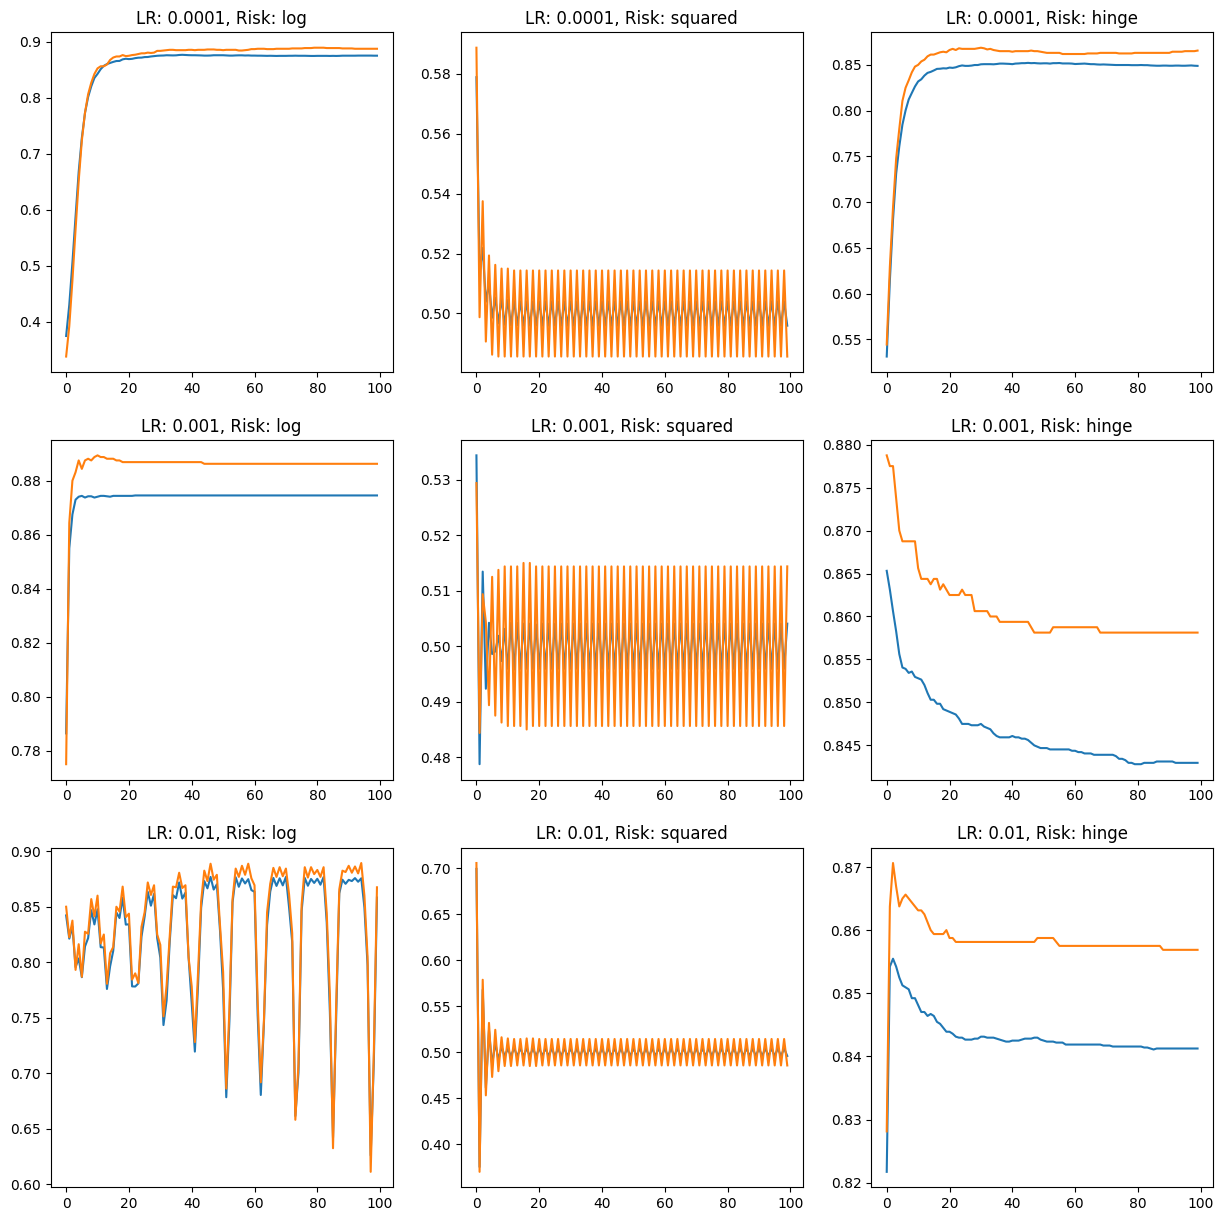

In [18]:
learning_rates = [0.0001, 0.001, 0.01]
risks = ["log", "squared", "hinge"]

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, lr in enumerate(learning_rates):
    for j, risk in enumerate(risks):
        ax = axs[i, j]
        model = LinearClassificationGD(learning_rate=lr, risk=risk)
        plot_learning_curve(ax, model, X_train, y_train, X_test, y_test, 100)
        ax.set_title(f"LR: {lr}, Risk: {risk}")

plt.show()

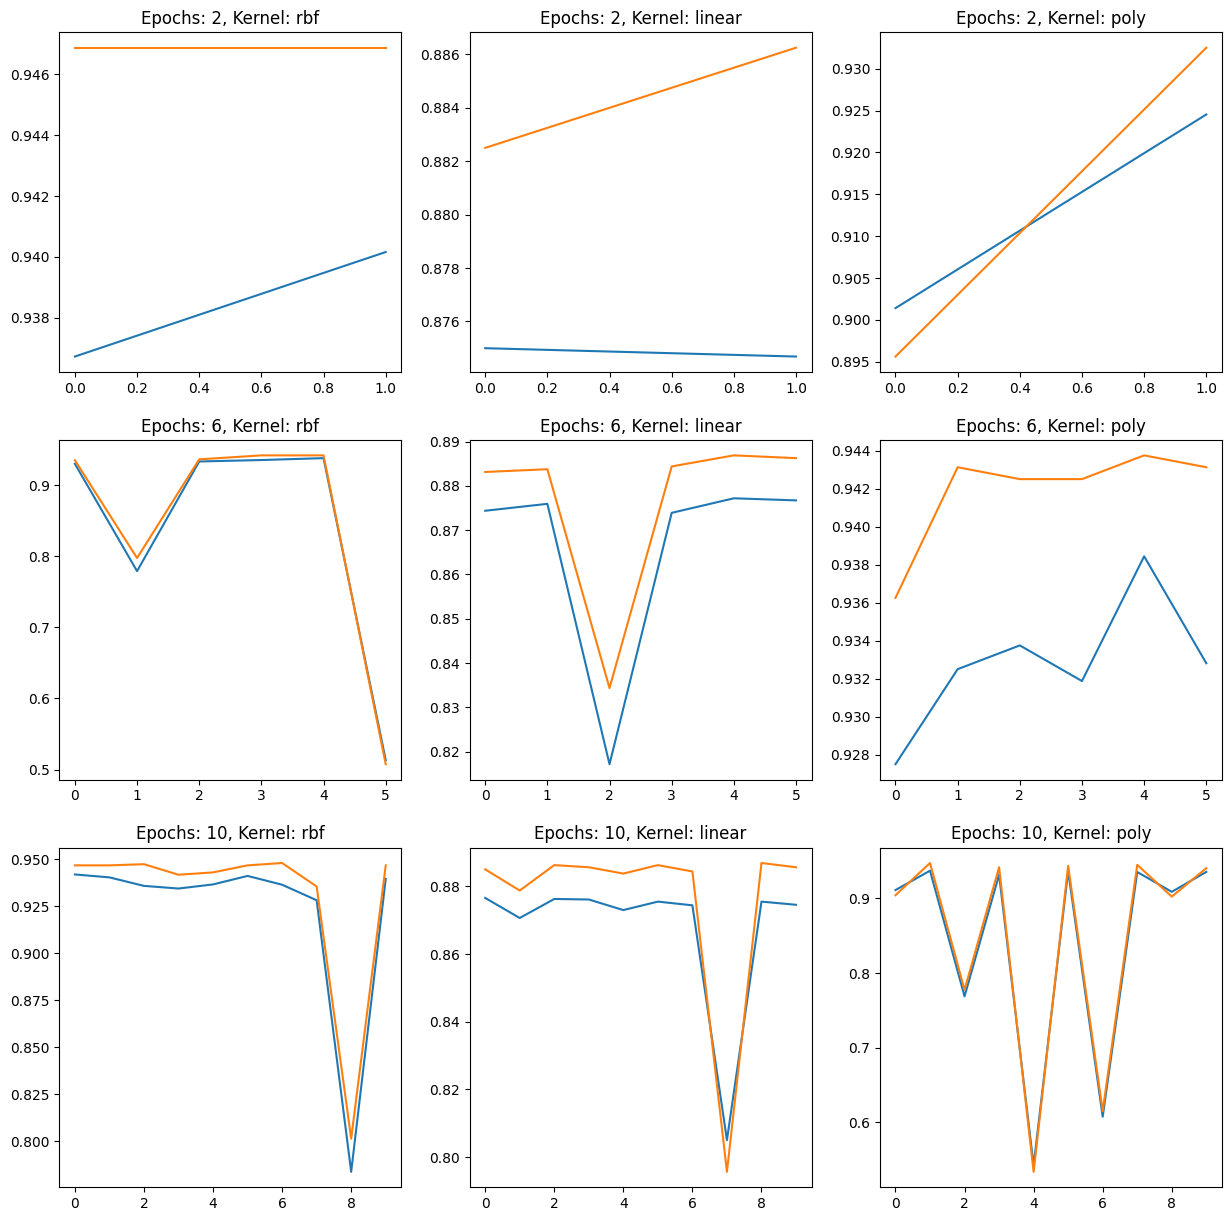

In [22]:
epochss = [2, 6, 10]
kernels = ["rbf", "linear", "poly"]

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, epochs in enumerate(epochss):
    for j, kernel in enumerate(kernels):
        ax = axs[i, j]
        model = SVM(epochs=epochs, kernel=kernel)
        plot_learning_curve(ax, model, X_train, y_train, X_test, y_test, epochs)
        ax.set_title(f"Epochs: {epochs}, Kernel: {kernel}")

plt.show()

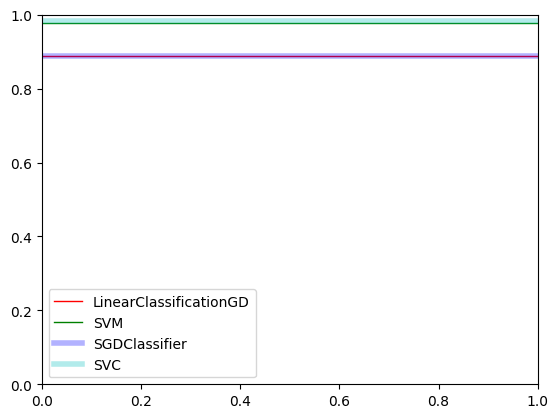

In [24]:
import matplotlib.pyplot as plt

best_models = {
    LinearClassificationGD: (study_linear.best_trial.params, 'r', 1, 1),
    SVM: (study_svm.best_trial.params, 'g', 1, 1),
    SGDClassifier: (study_linear_sklearn.best_trial.params, 'b', 4, 0.3),
    SVC: (study_svm_sklearn.best_trial.params, 'c', 4, 0.3),
}

for model, (params, color, linewidth, alpha) in best_models.items():
    tmp_model = model(**params)
    tmp_model.fit(X_train, y_train)
    best_models[model] = tmp_model
    line_level = accuracy_score(y_test, tmp_model.predict(X_test))
    plt.axhline(y=line_level, color=color, linewidth=linewidth, alpha=alpha, linestyle='-', label=model.__name__)
    
plt.legend()
plt.show()

### Compare coefs & vectors

In [26]:
linears = [best_models[LinearClassificationGD], best_models[SGDClassifier]]
svms = [best_models[SVM], best_models[SVC]]

In [32]:
linears[0].w, linears[1].coef_

(array([ 1.36354078,  1.83262462,  1.49738003,  0.18512528,  1.06115764,
         1.18820184, -0.17822293]),
 array([[ 0.32271622,  0.36303196,  0.3364384 ,  0.04764489,  0.24945256,
          0.26439949, -0.05068134]]))

In [47]:
linears[0].w / linears[1].coef_

array([[4.22520068, 5.04810819, 4.45068112, 3.88552194, 4.25394563,
        4.49396425, 3.51653929]])

То есть почти коллинеарны (градиентный спуск устремился вдоль одного напрвления)

In [46]:
print(f"Base: {svms[0].get_support_vectors()}\nscikit: {svms[1].support_vectors_}")
print(len(svms[0].get_support_vectors()), len(svms[1].support_vectors_))

Base: [[ 0.65052024 -0.64381167  0.82582284 ...  0.57004436 -0.25717558
  -2.56105573]
 [ 0.25872199  0.6799747  -2.0136258  ...  1.49176132 -0.38218797
   1.21410858]
 [-1.70500425  1.35897627  1.16835545 ... -0.61165409  0.6285791
   1.12062478]
 ...
 [-1.82415667  1.23119216 -0.76183418 ... -0.8384735   0.73080567
  -0.98882617]
 [-1.67418257  0.21096215  0.09357095 ... -1.11813571 -1.17077218
  -0.8548178 ]
 [ 0.70039364  2.06513914  2.33776507 ...  0.44983384 -0.24822449
   0.3059451 ]]
scikit: [[-0.2848209  -1.45520367 -0.72790385 ...  0.76027685  1.16634549
  -0.84131621]
 [-0.67907657  1.2835559  -1.09602033 ...  1.88441387 -1.95229027
   2.39340405]
 [ 0.57008284  0.16855496 -0.55460359 ... -0.61287766  0.89195816
  -0.8701688 ]
 ...
 [ 0.28242972  0.24420238 -1.49777741 ... -0.26509289 -0.24765033
  -0.50451669]
 [-1.7913639  -0.20750192  0.52346021 ... -1.36241886 -0.58801034
  -0.17018697]
 [ 1.05560171 -1.22349956 -0.18762043 ...  1.99251818  0.32216282
  -0.28148689]]
140